In [108]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visual plots
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler

# DataLoader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# LSTM Model + Lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = torch.device('mps')


In [21]:

######## Data preprocessing ###########
def get_process_data(file_path:str) -> pd.DataFrame:
    df = pd.read_csv(file_path, na_values='N/E')

    # Change columns names
    df.rename(columns={'Fecha': 'Date', 'SP30578': 'INPC'})

    # Change name and the type of the data
    df.rename(columns={'Fecha': 'Date', 'SP30578': 'INPC'}, inplace=True)
    df.dropna(subset='INPC', inplace=True)
    df['INPC'] = df['INPC'].astype(float)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df.set_index('Date', inplace=True) # Set the index on TIME PERIOD
    df = df["INPC"]
    return df

# Define the LSTM model
class LitLSTMModel(L.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, output_size, learning_rate):
        super(LitLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.learning_rate = learning_rate

    def forward(self, x):
        lstm_out, _ = self.lstm(x) # lstm_out = (batch_size, seq_len, hidden_size)
        out = self.fc(lstm_out[:,-1])
        return out
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y = batch
        outputs = self.forward(x)
        loss = F.mse_loss(outputs, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        outputs = self.forward(x)
        loss = F.mse_loss(outputs, y)
        self.log('test_loss', loss, prog_bar=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        outputs = self.forward(x)
        loss = F.mse_loss(outputs, y)
        self.log('validation_loss', loss, prog_bar=True)
        return loss
    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


class LitTimeSeriesDataModule(L.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, seq_length, batch_size):
        super(LitTimeSeriesDataModule, self).__init__()
        self.save_hyperparameters()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.seq_length = seq_length
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = TimeSeriesDataset(self.train_data, self.seq_length)
        self.val_dataset = TimeSeriesDataset(self.val_data, self.seq_length)
        self.test_dataset = TimeSeriesDataset(self.test_data, self.seq_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=10, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=10, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=10, persistent_workers=True)

# Split into Training, Testing and Validation

def train_test_val_time_series_split(data, train_size:float, val_size:float, test_size:float):
    # Steps
    train_size = int(len(data) * 0.7)
    val_size = int(len(data) * 0.2)
    test_size = int(len(data) * 0.1) + 1 # matches the total data set
    
    print(f'Train size: {train_size}')
    print(f'Test size: {val_size}')
    print(f'Validation size: {test_size}')
    print(f'Dataset size: {data.shape[0]}')
    
    # Split the data
    return np.array(data[:train_size]), np.array(data[train_size:train_size + val_size]), np.array(data[train_size + val_size:])

In [22]:
# Data collection
file_path = './data/INPC_Mexico.csv'
df = get_process_data(file_path)


In [23]:
# Hyper-parameters
input_size = 1 # Number of features in the input
hidden_size = 128 # Number of features in the hidden state
num_layers = 4
output_size = 1 
learning_rate = 0.0001
num_epochs = 20
seq_length = 12
batch_size = 10
max_epochs = 20


In [24]:
df_copy = df.values.reshape(-1, 1).copy()
train_data, val_data, test_data = train_test_val_time_series_split(df_copy, train_size=0.7, val_size=0.2, test_size=0.1)

# Scale the data
scaler = StandardScaler().fit(train_data) # Initialize the Scaler
scaled_data_train = scaler.transform(train_data)
scaled_data_validation = scaler.transform(val_data)
scaled_data_test = scaler.transform(test_data)

# Create the DataModule
data_module = LitTimeSeriesDataModule(scaled_data_train, scaled_data_validation, scaled_data_test, seq_length, batch_size)
model = LitLSTMModel(input_size, hidden_size, num_layers, output_size, learning_rate)
save_model_path = "./models/best_model_lightning.ckpt"


Train size: 457
Test size: 130
Validation size: 66
Dataset size: 653


In [128]:
# Function to predict next n_steps using the model
def predict_future(model, initial_data_scaled, n_steps, scaler):    
    model.eval()
    predictions = []
    current_seq = initial_data_scaled.copy()

    for _ in range(n_steps):
        input_seq = torch.tensor(current_seq).unsqueeze(0).float().to(device)  # Shape: (1, seq_length, 1)
        with torch.no_grad():
            next_value = model(input_seq).item()
        predictions.append(next_value)
        
        # Update current_seq: Drop the first element and append the predicted value
        current_seq = np.append(current_seq[1:], next_value).reshape(-1, 1)

    # Inverse transform the predictions
    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original = scaler.inverse_transform(predictions).flatten()

    return predictions_original

In [145]:
predictions = []
initial_data = df.values[-seq_length:].reshape(-1, 1)  # Last seq_length points to start predictions
initial_data_scaled = scaler.transform(initial_data) # transform
input_seq = torch.tensor(initial_data_scaled).unsqueeze(0).float().to(device)  # Shape: (1, seq_length, 1)
current_seq = initial_data_scaled.copy()

for _ in range(7):
    input_seq = torch.tensor(current_seq).unsqueeze(0).float().to(device)  # Shape: (1, seq_length, 1)

    with torch.no_grad():
        next_value = model(input_seq).item()
    predictions.append(next_value)

    # Update current_seq: Drop the first element and append the predicted value
    current_seq = np.append(current_seq[1:], next_value).reshape(-1, 1)


In [149]:
predictions

[-0.6689214110374451,
 -0.6689379215240479,
 -0.6676911115646362,
 -0.6651803255081177,
 -0.661469578742981,
 -0.6568145751953125,
 -0.65170818567276]

In [150]:
predictions = np.array(predictions).reshape(-1, 1)

scaler.inverse_transform(predictions).flatten()

array([6.18454101, 6.18398532, 6.22594907, 6.31045433, 6.43534655,
       6.59201951, 6.76388473])

In [140]:
scaler.inverse_transform(np.array(next_value).reshape(-1, 1))

array([[6.18454101]])

In [136]:
initial_data_scaled

array([[-0.70233332],
       [-0.71035545],
       [-0.71481219],
       [-0.72045739],
       [-0.72610259],
       [-0.7243199 ],
       [-0.71421795],
       [-0.7076814 ],
       [-0.72194297],
       [-0.72134874],
       [-0.71451507],
       [-0.71332661]])

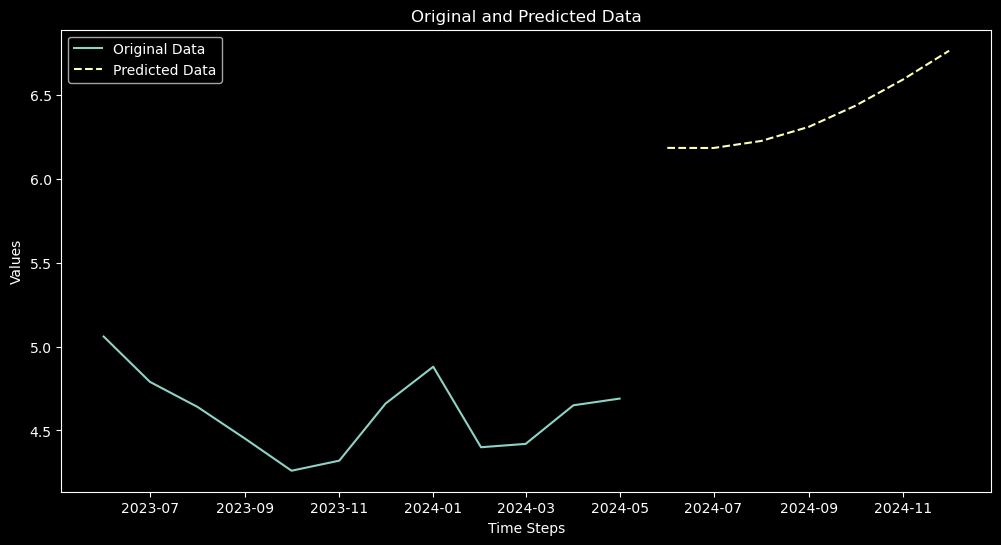

In [151]:
model = LitLSTMModel.load_from_checkpoint(save_model_path)
# Use the last seq_length points from the test data to start predictions
initial_data = df.values[-seq_length:].reshape(-1, 1)  # Last seq_length points to start predictions
initial_data_scaled = scaler.transform(initial_data) # transform

n_steps = 7
predictions_future = predict_future(model, initial_data_scaled, n_steps, scaler)

############ Prepare for predictions ##################
predicition_dates = ['2024-06-01', '2024-07-01', '2024-08-01',
                    '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01']

df_prediction = df[-seq_length:].reset_index().copy()
df_future = pd.DataFrame({'Date': predicition_dates, 'predictions': predictions_future})
df_future = pd.concat([df_prediction, df_future])

plt.figure(figsize=(12, 6))
plt.plot(df_future['Date'], df_future['INPC'], label='Original Data')
plt.plot(df_future['Date'], df_future['predictions'], label='Predicted Data', linestyle='--')
#plt.axvline(x=len(df_future)-1, color='r', linestyle='--')  # Line separating original and predicted data
plt.title('Original and Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()

In [135]:
predictions_future


array([120.62216675, 120.2313289 , 119.37044407, 118.01367359,
       116.23211391, 114.13134243, 111.82150248])

In [133]:
initial_data

array([[5.06],
       [4.79],
       [4.64],
       [4.45],
       [4.26],
       [4.32],
       [4.66],
       [4.88],
       [4.4 ],
       [4.42],
       [4.65],
       [4.69]])

In [132]:
initial_data_scaled

array([[-0.70233332],
       [-0.71035545],
       [-0.71481219],
       [-0.72045739],
       [-0.72610259],
       [-0.7243199 ],
       [-0.71421795],
       [-0.7076814 ],
       [-0.72194297],
       [-0.72134874],
       [-0.71451507],
       [-0.71332661]])